In [2]:
%pip install sklearn
%pip install pillow
%pip install torchvision
%pip install imbalanced-learn
%pip install einops
!unzip '/content/images.zip'

  Using cached sklearn-0.0.post9.tar.gz (3.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Archive:  /content/images.zip
replace images/MHIST_djh.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: images/MHIST_djh.png    
  inflating: images/MHIST_dis.png    
  inflating: images/MHIST_atj.png    
  inflating: images/MHIST_cou.png    
  inflating: images/MHIST_awq.png    
  inflating: images/MHIST_cln.png    
  inflating: images/MHIST_aun.png    
  inflating: images/MHIST_cnq.png    
  inflating: images/MHIST_avu.png    
  inflating: images/MHIS

**Dataset**

The dataset is called "MHIST: A Minimalist Histopathology Image Analysis Dataset". It contains 3152 fixed size(224 by 224) images of colorectal plyops. Each image is classified as either a Hyperplastic Plyop(HP) or Sessile Serated Adenoma(SSA), by the majority consensus of a team of 7 pathologists. You can find the dataset here: https://bmirds.github.io/MHIST/

In [15]:
import PIL as Image
import torch
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from skimage import io
from sklearn.model_selection import train_test_split

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.set_per_process_memory_fraction(0.9)
torch.cuda.empty_cache()

#Preparing the dataset
annotations = pd.read_csv('/content/annotations.csv')
HP = annotations.iloc[:,1] == "HP"
SSA = annotations.iloc[:,1] == "SSA"
annotations["HP"] = HP
annotations["SSA"] = SSA
t_annotations = annotations[annotations["Partition"]=="train"]

train_annotations, val_annotations = train_test_split(t_annotations,
                                                      train_size=0.8,
                                                      stratify=
                                                      t_annotations["HP"])

# Just to confirm if the distribution is the same
print(len(train_annotations[HP] == True), len(train_annotations))
print(len(val_annotations[HP] == True), len(val_annotations))
test_annotations = annotations[annotations["Partition"]=="test"]
root_dir = '/content/images'

class Plyops(Dataset):
  def __init__(self, annotations, root_dir, transform = None) -> None:
    self.annotations = annotations
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)

    if self.transform:
      image = self.transform(image)

    y_label = torch.tensor([int(self.annotations.iloc[index, 4]),
                            int(self.annotations.iloc[index, 5])])
    return (image, y_label)


train_dataset = Plyops(train_annotations, root_dir)
val_dataset = Plyops(val_annotations, root_dir)
test_dataset = Plyops(test_annotations, root_dir)

batch_size = 16

train_dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size),
                     'val': DataLoader(val_dataset, batch_size=batch_size)}
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset)//2)

dataset_sizes = {'train': len(train_dataloaders['train']),
                 'val': len(train_dataloaders['val']),
                 'test': len(test_dataloader)}

1236 1740
309 435


<ipython-input-15-111d8be24ca9>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(train_annotations[HP] == True), len(train_annotations))
<ipython-input-15-111d8be24ca9>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(val_annotations[HP] == True), len(val_annotations))


**Models**

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from einops.einops import rearrange

class fc(nn.Module):
  def __init__(self):
    super(fc, self).__init__()
    self.fc1 = nn.Linear(224*224*3, 4096)
    self.bn1 = nn.BatchNorm1d(4096, affine=False)
    self.act1 = nn.ReLU()
    self.fc2 = nn.Linear(4096, 1024)
    self.bn2 = nn.BatchNorm1d(1024, affine=False)
    self.act2 = nn.ReLU()
    self.fc3 = nn.Linear(1024, 2)
    self.softmax = nn.Softmax(dim=1)


  def forward(self, x):
    x = rearrange(x, 'b h w c -> b (h w c)')
    x = self.act1(self.bn1(self.fc1(x)))
    x = self.act2(self.bn2(self.fc2(x)))
    x = self.softmax(self.fc3(x))
    return x


**Training and Testing**

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def visualize(*args, labels):
  n = len(args[0])
  x = np.arange(0,n, 1)
  assert len(args) == len(labels), "Each list must have a corresponding label"
  #Defining the functions used for plotting
  for i in range(len(args)):
    assert len(args[i]) == n, "incorrect number of values"
    plt.plot(x, args[i], label = labels[i])
  plt.xlim(0,n-1)
  plt.xticks(range(0,n-1))
  plt.ylim(0,1)
  plt.title("Model Evaluation")
  plt.xlabel("Epochs")
  plt.ylabel("Metrics")
  plt.legend()
  plt.show()

def visualize_training(*args):
  labels = ["Precision", "Recall", "F1", "Specificity"]
  visualize(*args, labels= labels)

def visualize_testing(c_matrix):
  pass

In [6]:
from numpy import mean
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score


def training_loop(dataloader, model, epochs, loss_function, optimizer, scheduler = None):
  epoch_losses = []
  epoch_precisions = []
  epoch_recalls = []
  epoch_f1_scores = []
  epoch_specificities = []
  for epoch in range(epochs):
    print("Epoch: " + str(epoch))
    batch_tn = []
    batch_fp = []
    batch_tp = []
    batch_fn = []
    batch_losses = []
    for x in ['train', 'val']:
      model.to(device)
      if x == 'train':
        model.train()
      else:
        model.eval()
      for (data, label) in dataloader[x]:
        data = data.to(torch.float32)
        label = label.to(torch.float32)
        data, label = data.to(device), label.to(device)
        output = model(data)
        output.to(device)
        loss = loss_function(output, label)
        optimizer.zero_grad()
        with torch.no_grad():
          predictions = torch.argmax(output.to('cpu'), 1)
          label = torch.argmax(label.to('cpu'), 1)
          tn, fp, fn, tp = confusion_matrix(label, predictions, labels=[0,1]).ravel()

        if x == 'train':
          loss.backward()
          optimizer.step()
        else:
          batch_losses.append(loss.item())
          batch_tn.append(tn)
          batch_fp.append(fp)
          batch_tp.append(tp)
          batch_fn.append(fn)

    epoch_loss = mean(batch_losses)
    epoch_losses.append(epoch_loss)
    epoch_tn, epoch_fp, epoch_tp, epoch_fn = sum(batch_tn), sum(batch_fp), sum(batch_tp), sum(batch_fn)

    if scheduler:
        scheduler.step(epoch_loss)

    epoch_precision = epoch_tp/(epoch_tp + epoch_fp) if epoch_tp + epoch_fp != 0 else 0
    epoch_precisions.append(epoch_precision)
    epoch_recall = epoch_tp/(epoch_tp + epoch_fn) if epoch_tp + epoch_fp != 0 else 1
    epoch_recalls.append(epoch_recall)
    epoch_f1 = (2*epoch_recall*epoch_precision)/(epoch_recall + epoch_precision) if epoch_recall + epoch_precision != 0 else 0
    epoch_f1_scores.append(epoch_f1)
    epoch_specificity = epoch_tn/(epoch_tn + epoch_fp) if epoch_tn + epoch_fp != 0 else 1
    epoch_specificities.append(epoch_specificity)

    print("Precision: " + str(epoch_precision)
          + " F1: " + str(epoch_f1))
    print("Recall: " + str(epoch_recall) + " Specificity: " + str(epoch_specificity))
    print("Loss: " + str(epoch_loss))

  return [epoch_precisions, epoch_recalls, epoch_f1_scores, epoch_specificities]


Epoch: 0
Precision: 0.47794117647058826 F1: 0.4961832061068703
Recall: 0.5158730158730159 Specificity: 0.7702265372168284
Loss: 0.621248589030334
Epoch: 1
Precision: 0.43005181347150256 F1: 0.5203761755485893
Recall: 0.6587301587301587 Specificity: 0.6440129449838188
Loss: 0.8381550152386937
Epoch: 2
Precision: 0.46875 F1: 0.5244755244755245
Recall: 0.5952380952380952 Specificity: 0.7249190938511327
Loss: 0.9509931137519223
Epoch: 3
Precision: 0.4838709677419355 F1: 0.48
Recall: 0.47619047619047616 Specificity: 0.7928802588996764
Loss: 0.9781323509024722
Epoch: 4
Precision: 0.675 F1: 0.5242718446601942
Recall: 0.42857142857142855 Specificity: 0.9158576051779935
Loss: 0.7246512344905308
Epoch: 5
Precision: 0.6705882352941176 F1: 0.5402843601895734
Recall: 0.4523809523809524 Specificity: 0.9093851132686084
Loss: 0.7124131619930267
Epoch: 6
Precision: 0.6627906976744186 F1: 0.5377358490566038
Recall: 0.4523809523809524 Specificity: 0.9061488673139159
Loss: 0.7153159805706569
Epoch: 7
Prec

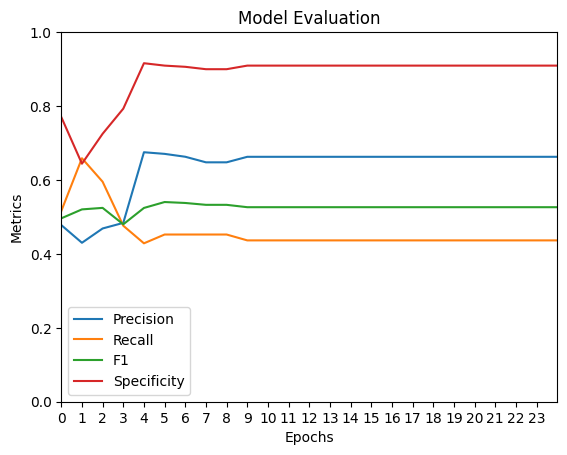

In [14]:
import torch.optim as optim
#large learning rate since not much time to train
lr = 5e-4
model = fc()

loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)

epochs = 25

args = training_loop(train_dataloaders, model, epochs, loss_function, optimizer, scheduler)

visualize_training(*args)


Lets test the model

In [10]:
import itertools
from tabulate import tabulate

def test(test_dataloader, model):
  model.to(device)
  model.eval()
  #Assumes that batch_size = len(test_dataloader)
  for data, label in test_dataloader:
    data = data.to(torch.float32)
    label = label.to(torch.float32)
    data, label = data.to(device), label.to(device)
    output = model(data)
    with torch.no_grad():
      predictions = torch.argmax(output.to('cpu'), 1)
      label = torch.argmax(label.to('cpu'), 1)
      return confusion_matrix(label, predictions, labels=[0,1]), classification_report(label, predictions, output_dict=True)

def visualize_testing(cm):
  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, [0,1], rotation=45)
  plt.yticks(tick_marks, [0,1])
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')



[[549  68]
 [195 165]]
╒═════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Label   │   Precision │   Recall │   F1-score │   Support │
╞═════════╪═════════════╪══════════╪════════════╪═══════════╡
│ HP      │    0.737903 │ 0.889789 │   0.80676  │       617 │
├─────────┼─────────────┼──────────┼────────────┼───────────┤
│ SSA     │    0.708155 │ 0.458333 │   0.556492 │       360 │
╘═════════╧═════════════╧══════════╧════════════╧═══════════╛


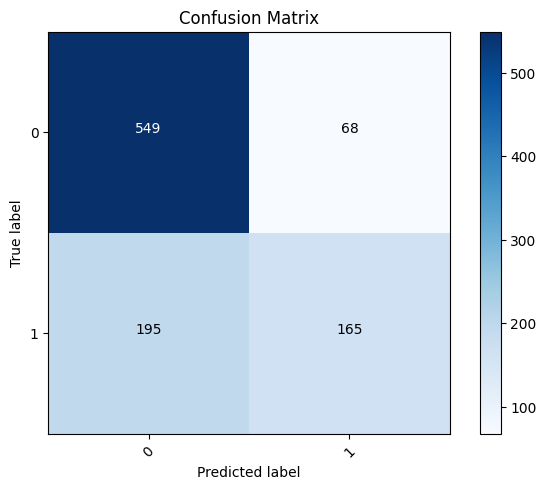

In [19]:
cm, cr = test(test_dataloader, model)
visualize_testing(cm)
data = {"Label": ["HP", "SSA"], "Precision": [cr['0']['precision'], cr['1']['precision']], "Recall": [cr['0']['recall'], cr['1']['recall']],
        "F1-score":[cr['0']['f1-score'], cr['1']['f1-score']], "Support": [cr['0']['support'], cr['1']['support']]}
print(tabulate(data, headers="keys", tablefmt="fancy_grid"))

Surprisingly, the model performes reasonably well. Lets see how it performs after we balance the dataset. In order to balance the dataset, we will use random-oversampling, and random-undersampling and analyze the impact of each

**Balancing the Dataset**

In [20]:
from imblearn.over_sampling import RandomOverSampler

#We are going to apply random transformation to each of the training examples, and see their effect on the model in addition
#Note that t_annotations is only the training data not the testing
ros = RandomOverSampler(random_state=0)
t_annotations_data, t_annotations_target = ros.fit_resample(t_annotations.drop(["HP"], axis=1), t_annotations['HP'])
print(len(t_annotations_data["SSA"] == True), len(t_annotations_data["SSA"] == False))
t_annotations_data["HP"] = t_annotations_target
train_annotations_ros, val_annotations_ros = train_test_split(t_annotations_data, train_size=0.8, stratify=t_annotations_data["HP"])


#Below is the training dataset without transformations applied
train_dataset_ros2 = Plyops(train_annotations_ros, root_dir)
val_dataset_ros2 = Plyops(val_annotations_ros, root_dir)

batch_size = 16

train_dataloaders_ros2 = {'train': DataLoader(train_dataset_ros2, batch_size=batch_size),
                                                    'val': DataLoader(val_dataset_ros2, batch_size=batch_size)}

3090 3090


In [19]:
import torch.optim as optim
torch.cuda.empty_cache()

#large learning rate since not much time to train
lr = 5e-4
model = fc()

loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)

epochs = 25

args = training_loop(train_dataloaders, model, epochs, loss_function, optimizer, scheduler)

visualize_training(*args)


Epoch: 0


OutOfMemoryError: ignored

[[386  36]
 [ 45  21]]
╒═════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Label   │   Precision │   Recall │   F1-score │   Support │
╞═════════╪═════════════╪══════════╪════════════╪═══════════╡
│ HP      │    0.895592 │ 0.914692 │   0.905041 │       422 │
├─────────┼─────────────┼──────────┼────────────┼───────────┤
│ SSA     │    0.368421 │ 0.318182 │   0.341463 │        66 │
╘═════════╧═════════════╧══════════╧════════════╧═══════════╛


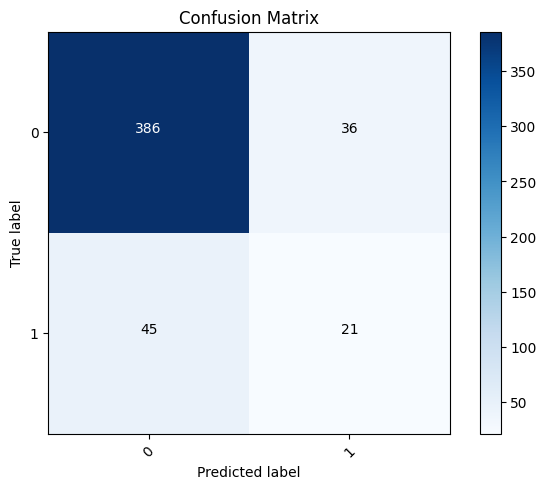

In [12]:
cm, cr = test(test_dataloader, model)
visualize_testing(cm)
data = {"Label": ["HP", "SSA"], "Precision": [cr['0']['precision'], cr['1']['precision']], "Recall": [cr['0']['recall'], cr['1']['recall']],
        "F1-score":[cr['0']['f1-score'], cr['1']['f1-score']], "Support": [cr['0']['support'], cr['1']['support']]}
print(tabulate(data, headers="keys", tablefmt="fancy_grid"))

The results are better, lets try undersampling now

**Random Undersampling**

In [7]:
from imblearn.under_sampling import RandomUnderSampler
#Now lets try random undersampling
rus = RandomUnderSampler(random_state=0)
t_annotations_data, t_annotations_target = rus.fit_resample(t_annotations.drop(["HP"], axis=1), t_annotations['HP'])
print(len(t_annotations_data["SSA"] == True), len(t_annotations_data["SSA"] == False))
t_annotations_data["HP"] = t_annotations_target
train_annotations_rus, val_annotations_rus = train_test_split(t_annotations_data, train_size=0.8, stratify=t_annotations_data["HP"])

#Below is the training datasets
train_dataset_rus = Plyops(train_annotations_rus, root_dir)
val_dataset_rus = Plyops(val_annotations_rus, root_dir)

batch_size = 16

train_dataloaders_rus = {'train': DataLoader(train_dataset_rus, batch_size=batch_size),
                                                    'val': DataLoader(val_dataset_rus, batch_size=batch_size)}

1260 1260


Epoch: 0
Precision: 0.42028985507246375 F1: 0.5225225225225225
Recall: 0.6904761904761905 Specificity: 0.6116504854368932
Loss: 0.6878041241850171
Epoch: 1
Precision: 0.3886792452830189 F1: 0.5268542199488492
Recall: 0.8174603174603174 Specificity: 0.47572815533980584
Loss: 0.9676988848618099
Epoch: 2
Precision: 0.5121951219512195 F1: 0.40384615384615385
Recall: 0.3333333333333333 Specificity: 0.8705501618122977
Loss: 0.8721276852634868
Epoch: 3
Precision: 0.49162011173184356 F1: 0.5770491803278688
Recall: 0.6984126984126984 Specificity: 0.7055016181229773
Loss: 0.7185505660516875
Epoch: 4
Precision: 0.592 F1: 0.5896414342629482
Recall: 0.5873015873015873 Specificity: 0.8349514563106796
Loss: 0.6870793758758477
Epoch: 5
Precision: 0.6808510638297872 F1: 0.5818181818181817
Recall: 0.5079365079365079 Specificity: 0.9029126213592233
Loss: 0.7322452410922519
Epoch: 6
Precision: 0.6774193548387096 F1: 0.5753424657534247
Recall: 0.5 Specificity: 0.9029126213592233
Loss: 0.742283398152462
Epo

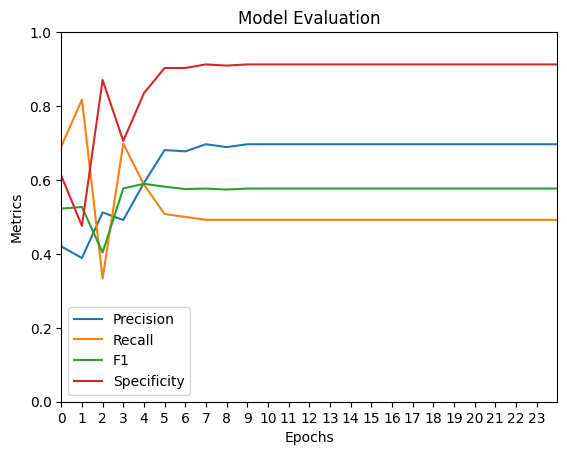

In [8]:
import torch.optim as optim
#large learning rate since not much time to train
lr = 5e-4
model = fc()

loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay=5e-4, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)

epochs = 25

args = training_loop(train_dataloaders, model, epochs, loss_function, optimizer, scheduler)

visualize_training(*args)


[[386  36]
 [ 45  21]]
╒═════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Label   │   Precision │   Recall │   F1-score │   Support │
╞═════════╪═════════════╪══════════╪════════════╪═══════════╡
│ HP      │    0.895592 │ 0.914692 │   0.905041 │       422 │
├─────────┼─────────────┼──────────┼────────────┼───────────┤
│ SSA     │    0.368421 │ 0.318182 │   0.341463 │        66 │
╘═════════╧═════════════╧══════════╧════════════╧═══════════╛


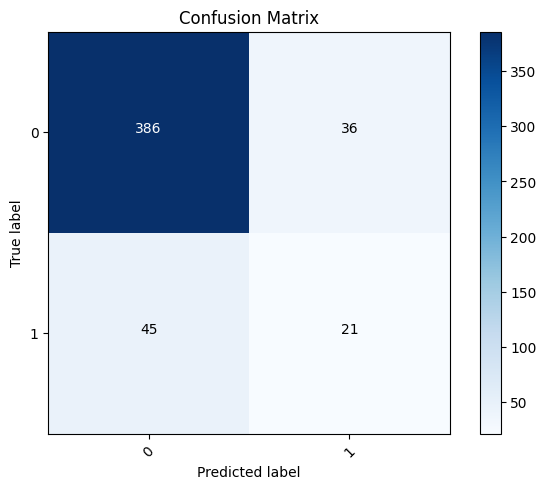

In [11]:
cm, cr = test(test_dataloader, model)
visualize_testing(cm)
data = {"Label": ["HP", "SSA"], "Precision": [cr['0']['precision'], cr['1']['precision']], "Recall": [cr['0']['recall'], cr['1']['recall']],
        "F1-score":[cr['0']['f1-score'], cr['1']['f1-score']], "Support": [cr['0']['support'], cr['1']['support']]}
print(tabulate(data, headers="keys", tablefmt="fancy_grid"))

The metrics are better for the HP class, but also substantially worse for the SSA class. This is not much of an improvement as HP is the majority class. In practical applications,we want to able to detect the cancerous cells

**Summary**

Fully connected neural networks are usually not used in computer vision tasks, so I was surprised at the effectiveness this model. Applying Random-Oversampling to the model only improved the performance metrics marginally. Applying Random-Undersampling improved the metrics for the majority class, but the metrics for the minority class was significantly worse. Arguably, the performance on the minority class is more important for practical applications

**Note**
- There was unresolved out of memory issues, when I tried to perform testing after balancing the dataset with random undersampling. For this endeavour, only half of the testing samples were used.
- The testing results for the oversampling case are incorrect,

**References**

1. Jerry Wei, Arief Suriawinata, Bing Ren, Xiaoying Liu, Mikhail Lisovsky, Louis Vaickus, Charles Brown, Michael Baker, Naofumi Tomita, Lorenzo Torresani, Jason Wei, Saeed Hassanpour, “A Petri Dish for Histopathology Image Analysis”, International Conference on Artificial Intelligence in Medicine (AIME), 12721:11-24, 2021